# 2D Oblique Sphere Collisions

Interactive code to illustrate concepts from MAT201 at Abertay University (JT 2022).

Using the maths we learned in lectures, we'll create a visualisation of a ball collision with another ball. Post-impact trajectories are determined by the solution of a set of simultaneous equations, for an initial set of speeds, angles, masses and coefficient of restitution. Impact takes place at origin for simplicity.

As always, we need to load in the Python libraries that we need to carry out the plotting, animation and (in this case) solve a set of simultaneous equations.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib.patches as patches
import random
import math
import sys
!{sys.executable} -m pip install --upgrade Ipython

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip


With the libraries ready, we can set up some of the initial conditions for our collision. We'll have two balls, labelled A and B, and each is associated with a mass, an initial speed and at some initial angle to the line of centers created when the two spheres meet:

In [2]:
# angle of incidence
alpha_A = 45.0
alpha_B = 45.0-180.0
#initial velocity (m/s)
u_A = 2.0
u_B = 2.0
# masses (kg)
m_A = 2.0
m_B = 2.0

We should also set up the coefficient of restitution and the step size in time of the simulation

In [3]:
# The coefficient of restitution for bounces (-v_up/v_down).
e = 0.5
# The time step for the animation (s)
dt = 0.05

We will once again be solving two equations of motion, one in the horizontal ($x$) direction and one in the vertical ($y$) direction. 
With our initial conditions, this means calculating initial components of velocity using trig functions (again noting that Python trig functions work in radians). The total velocity is therefore also the sum of each of these components squared.  

In [4]:
vx0_A = u_A * math.cos(math.radians(alpha_A))
vy0_A = u_A * math.sin(math.radians(alpha_A))
vx0_B = u_B * math.cos(math.radians(alpha_B))
vy0_B = u_B * math.sin(math.radians(alpha_B))
vA = math.sqrt(vx0_A * vx0_A + vy0_A * vy0_A) 
vB = math.sqrt(vx0_B * vx0_B + vy0_B * vy0_B) 

The initial position is trickier; the balls are travelling at different speeds and angles. 

Our tactic is to fix the collision to take place at $\left(x=0,y=0\right)$.  We know the velocity the balls travel at, and they are not accelerating; our first year CGT maths lets us work out a displacement through $s=ut+1/2at^2$, which reduces to $s=ut$ if $a=0$. 

So our $x$  and $y$ positions will behave like $(x,y)=(u_x t,u_y t)$ before the collision, which will take place at $t=0$. 

Our neat trick here is to pick a time *before* $t=0$ and see where the ball would be. I fix $t=-1$, and hence $(x,y)=(-u_x,-u_y)$ as our initial positions. 


In [5]:
# Initial position and velocity vectors.
x0_A, y0_A = -vx0_A, -vy0_A
x0_B, y0_B = -vx0_B, -vy0_B

Now that our initial positions are fixed, this will essentially also fix the size of our plotting area. We'll fix the extent of our plot to be twice as big as the largest initial displacement in x or y, in order to prevent either ball beginning off-screen.

In [6]:
lval = (max(abs(x0_A), abs(x0_B), abs(y0_A), abs(y0_B)))
extent = 2 * int(math.ceil(lval))

We now have to deal with what happens when the balls collide.
In MAT201 we learned that 2D sphere collisions essentially boil down to:

1.   perpendicular velocities remain unchanged
2.   conservation of momentum (parallel to LOC):

$$ 
m_{1}U_{1}\cos{\alpha}+m_{2}U_{2}\cos{\beta}=m_{1}v_{1}+m_{2}v_{2} 
$$

3.   Newton's Law of Restitution (parallel to LOC):

$$ 
v_{2}-v_{1}=e\left(U_{1}\cos{\alpha}-U_{2}\cos{\beta}\right). 
$$

The first item fixes the $y$-components of velocity; the final two equations reduce to a set of simultaneous equations to solve for $v_x$ of each particle. 

When we tackle these problems by hand, we usually use substitution or row operations. Python is excellent at solving simultaneous equations (as we will see), provided we format the simultaneous equations in matrix form $Ax=B$. This then means that the solutions are given by inverting matrix $A$ and multiplying it to the coefficients in $B$; mathematically, $A^{-1}Ax=Ix=A^{-1}B$ for identity matrix $I$. We'll therefore arrange some of the coefficients in the final two equations to be in the form of a matrix:

In [7]:
# matrix of coeffs (to use to solve simultaneous equations)
A = [[1, -1], [m_B, m_A]]

We know that the collisions will take place at the origin. However, we're moving in time using discreet timesteps; depending on the size of dt, we might not actually hit the origin exactly, but potentially miss it by a small amount.

We'lll model each ball as a circle. Another way to detect a collision (without relying on it taking place at the origin) is to check if one of the circles overlaps the other. To do this, we'll make a function to check the distance between the centres of the circles. If the distance is less than the radius of each circle added together, then the circles have overlapped.

In [8]:
def overlap(x1, y1, x2, y2, r1, r2):
# subroutine to check if circles overlap  
    distSq = (x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2);
    radSumSq = (r1 + r2) * (r1 + r2);
    if (distSq == radSumSq):
        return 1
    elif (distSq > radSumSq):
        return -1
    else:
        return 0

We now need a function that returns the position of each ball over time.

We need this function iterate in time (by dt), and with each iteration, we need to check if the balls have overlapped using the overlap function we just created. If an overlap is detected, then we need to calculate the remaining coefficients in the simultaneous equations, and have Pythons linear algebra package ("linalg") solve the simultaneous equations and return the new velocities parallel to LoC.

In [9]:
def get_pos(t=0):
    global vA, vB
# position generation  
    """A generator yielding ball positions at time t."""
    x_A, y_A, vx_A, vy_A = x0_A, y0_A, vx0_A, vy0_A
    x_B, y_B, vx_B, vy_B = x0_B, y0_B, vx0_B, vy0_B
    xpos = [x_A, x_B]
    vA = math.sqrt(vx_A * vx_A + vy_A * vy_A) 
    vB = math.sqrt(vx_B * vx_B + vy_B * vy_B)
    ol = 0
    while all(i <= extent for i in xpos):
    # iterate while within bounds  
        t += dt
        x_A += vx_A * dt
        y_A += vy_A * dt
        x_B += vx_B * dt
        y_B += vy_B * dt        
        if (overlap(x_A,y_A,x_B,y_B,0.08,0.08) != -1) and (ol == 0) :
             # if impact detected, solve for new vx values
             ol = 1 # prevent repeated bounces
             Y = [e * (vx_A - vx_B), m_A * vx_A + m_B * vx_B]
             res = np.linalg.inv(A).dot(Y)  #solve simultaneous equations
             vx_B, vx_A = res[0], res[1]    #new velocities
             vA = math.sqrt(vx_A * vx_A + vy_A * vy_A) 
             vB = math.sqrt(vx_B * vx_B + vy_B * vy_B)
        yield x_A, y_A, x_B, y_B

In order to animate, we need to set up aspects of the figure and some initial parameters

In [10]:
def init():
    """Initialize the animation figure."""
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    ax.set_xlabel('$x$ (m)')
    ax.set_ylabel('$y$ (m)')
    lineA.set_data([],[])
    lineB.set_data([],[])
    lineA.set_data(xdata_A, ydata_A)
    lineB.set_data(xdata_B, ydata_B)
    ballA.set_center((x0_A, y0_A))
    ballB.set_center((x0_B, y0_B))
    v1_text.set_text('initial')
    v2_text.set_text('initial')
    return lineA, ballA, lineB, ballB, v1_text, v2_text,

The animation appends the position information (so that we can plot the trajectory of each ball), and also includes info on the total velocity of each ball to be printed as text on the figure in each frame.

In [11]:
def animate(pos):
    """For each frame, advance the animation to the new position, pos."""
    x_A, y_A, x_B, y_B = pos
    xdata_A.append(x_A)
    ydata_A.append(y_A)
    lineA.set_data(xdata_A, ydata_A)
    xdata_B.append(x_B)
    ydata_B.append(y_B)
    lineB.set_data(xdata_B, ydata_B)
    ballA.set_center((x_A, y_A))
    ballB.set_center((x_B, y_B))
    v1_text.set_text(f"$v= {vA:.3f} m/s$")
    v2_text.set_text(f"$v= {vB:.3f} m/s$")
    return lineA, ballA, lineB, ballB, v1_text, v2_text,

We're nearly there! Lets set up a figure, fix the size (using the extent variable from earlier), and plot a dashed line where the LoC should be. 

Note that, this LoC is simply for context, and is approximate: the collision actually takes place when an overlap is detected in the code, and so there may be a small offset between the plotted LoC and the true LoC location.

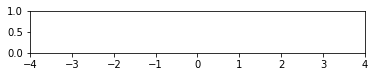

In [12]:
# Set up a new figure, with equal aspect ratio.
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.set_xlim(left=-extent, right=extent)
ax.set_aspect('equal')
ax.axhline(y=0, xmin=-extent, xmax=extent, c="black", linewidth=1, linestyle="--", zorder=0)

We also need to set up plot objects, like lines representing the trajectories and the circles representing the current location of each ball.

In [13]:
# These are the objects we need to keep track of.
lineA, = ax.plot([], [], lw=2, linestyle='dotted', color='blue')
lineB, = ax.plot([], [], lw=2, linestyle='dotted', color='red')
ballA = plt.Circle((x0_A, y0_A), 0.08, color='blue')
ballB = plt.Circle((x0_B, y0_B), 0.08, color='red')
v1_text = ax.text(-0.9 * extent, -0.9 * extent, '', color='blue')
v2_text = ax.text(0.5 * extent, 0.9 * extent, '', color='red')
ax.add_patch(ballA)
ax.add_patch(ballB)
xdata_A, ydata_A = [], []
xdata_B, ydata_B = [], []

Final step is to create the animation. The length of the simulation in time is the interval, and will impact the length of time the animation will take to create.

matplotlib: 3.7.1
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [14]:
interval = 1000*dt
ani = animation.FuncAnimation(fig, animate, get_pos, blit=True,
                      interval=interval, repeat=False, save_count=100)
from IPython.display import HTML
HTML(ani.to_html5_video())

Hopefully you will see a blue ball impacting a red ball close to the origin, no matter what initial velocity or angle is imparted to either sphere.

---



## Over To You

This worksheet illustrates how to use symbolic Python can solve a set of simultaneous equations for us: those equations happen to be conservation of linear momentum and Newton's Law of Restitution, and are applied to spheres which collide in 2D.


Try this for yourself: 


1. Change some of the constants in the problem: what happens when velocities or angles change?
2. Examine other lecture examples using this code:
    
One of the examples in the lecture had the following configuration:

*   Sphere A: mass $2$kg, speed $8\rm{ms}^{-1}$, angle of incidence $45^o$.
*   Sphere B: mass $2$kg, speed $0\rm{ms}^{-1}$ (angle of incidence irrelevant).
*  Coefficient of restitution $e=0.5$.

Rerun the simulation to confirm our post-collision findings in the lecture: 

$v_A=5.831\rm{ms}^{-1}$ at angle of $75.96^{o}$, $v_B=4.243\rm{ms}^{-1}$ at angle of $0^{o}$ (i.e. along the LoC).




---


The second example from the lectures stated

*   Sphere A: mass $8$kg, speed $4\rm{ms}^{-1}$, angle of incidence $30^o$.
*   Sphere B: mass $4$kg, speed $2\rm{ms}^{-1}$, angle of incidence $60^o$.
*  Coefficient of restitution $e=1/2$.

Rerun the simulation to confirm our post-collision findings in the lecture: 

$v_A=2.997\rm{ms}^{-1}$ at angle of $41.86^{o}$, $v_B=3.873\rm{ms}^{-1}$ at angle of $26.57^{o}$.
    
3. Attempt a few of the related tutorial questions, and see if you can confirm your worked solutions using the approaches demonstrated in this notebook. For example, you could confirm some of